In [11]:
from EEG2CodeKeras import (basearchi,
                           basearchitest_batchnorm,
                           basearchi_patchembedding,
                           basearchi_patchembeddingdilation,
                           trueVanilliaEEG2Code,
                           vanilliaEEG2Code,
                           vanilliaEEG2Code2,
                           EEGnet_Inception)
from _utils import make_preds_accumul_aggresive, make_preds_pvalue


from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.pipeline import make_pipeline
from pyriemann.estimation import XdawnCovariances, Xdawn
from pyriemann.tangentspace import TangentSpace
from pyriemann.classification import MDM
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from tensorflow import keras
import mne
from mne.decoding import Vectorizer
from mne.decoding import CSP
import os

import sys
import numpy as np
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
np.set_printoptions(threshold=sys.maxsize)
import matplotlib.pyplot as plt

sys.path.insert(0,"C:\\Users\\s.velut\\Documents\\These\\moabb\\moabb\\datasets")
sys.path.insert(0,"C:\\Users\\s.velut\\Documents\\These\\moabb\\moabb\\paradigms")
from castillos2023 import CasitllosCVEP100,CasitllosCVEP40,CasitllosBurstVEP100,CasitllosBurstVEP40
from cvep import BurstVEP



In [2]:
import tensorflow as tf
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [3]:
fps = 60
sfreq = 500


## Path to the data

In [12]:
dataset_moabb = CasitllosBurstVEP100()
paradigm = BurstVEP()
# print(paradigm.get_data(dataset_moabb,subjects=[1,2]))
raw = dataset_moabb.get_data(subjects=[1,2,3])[1]["0"]["0"]

Choosing the first None classes from all possible events.


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (3.302 s)

Using data from preloaded Raw for 60 events and 1101 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


RuntimeError: Don't know how to merge 'custom_ref_applied'. Make sure values are compatible, got types:
    [<class 'mne.utils._bunch.NamedInt'>, <class 'mne.utils._bunch.NamedInt'>]

In [5]:
# participant = 'P3'
# path = '/home/dcas/k.cabrera/Data/SET'
# n_class=11


# file_name = '_'.join([participant, 'whitemseq.set'])


#### Load channel positions

## Load the raw data and small pre-process
1. Drop the ACC channels and the shitty channels near ears
2. Average re-referencing
4. Extract 2.2s epochs using events

In [6]:
%matplotlib Qt

In [7]:
raw = mne.io.read_raw_eeglab(os.path.join(path, file_name), preload=True, verbose=False)

Used Annotations descriptions: ['0.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.21.1.1.1.0.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.21.1.1.1.0.20.20.20.20.20.20.20.20.20.20.20.20.20.21.1.1.1.0.20.20.20.20.20.20.20.20.20.20.20.20.21.1.1.1.0.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.21.1.1.1.0.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.21.1.1.1.0.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.21.1.1.1.0.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.21.1.1.1.0.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.21.1.1.1.0.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.21.1.1.1.0.20.20.20.20.20.20.20.20.20.20.20.20.20.21.1.1.1.0.20.20.20.20.20.20.20.20.20.20.20.20.21.1.1.1.0.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.21.1.1.1.0.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.21.1.1.1.0.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.21.1.1.1.0.20.20.20.20.20.20.20.20

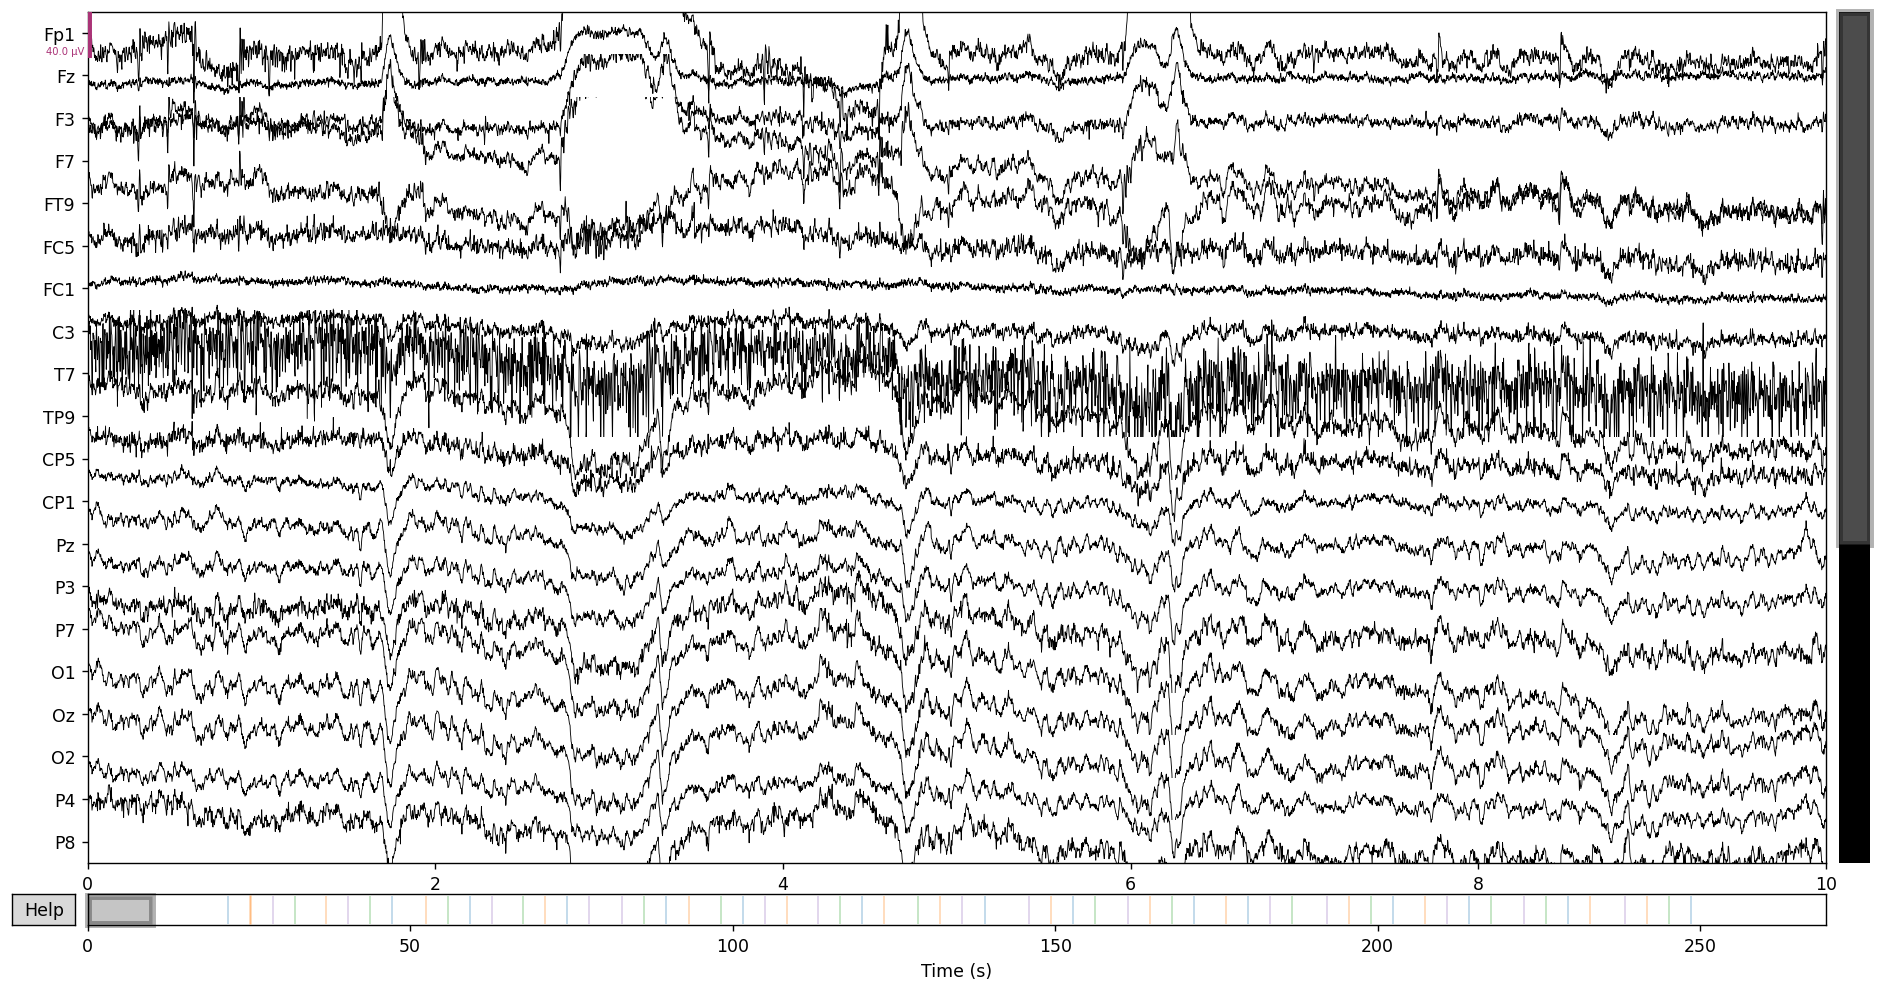

Channels marked as bad:
none


In [889]:
mne.events_from_annotations(raw)
raw.plot()

In [8]:
# montage = mne.channels.make_standard_montage("standard_1020")
# raw.set_montage(montage)
# raw.plot_sensors(show_names=True)
# raw.plot_psd()

In [8]:

print(raw.ch_names)
# to_drop = ["P9", "P10", "TP9", "TP10", "10", "21"]
# raw = raw.drop_channels([ch for ch in raw.ch_names if ch in to_drop])
# # raw = raw.drop_channels(["10", "21"])
# keep = ["O1", "O2", "Oz", "P7", "P3", "P4", "P8", "Pz"]
# keep = ["16", "18", "17", "15", "14", "19", "20", "13"] # electrodes to keep
# raw = raw.drop_channels([i for i in raw.ch_names if i not in keep])

# raw = raw.filter(l_freq=50.1, h_freq=49.9, method="iir", verbose=True)
raw = raw.filter(l_freq=1, h_freq=30, method="fir", verbose=True)
# raw = mne.filter.resample(raw,2)
# raw.resample(480, npad='auto')
# Average re-referencing
mne.set_eeg_reference(raw, 'average', copy=False, verbose=False)
#raw = raw.filter(l_freq=5, h_freq=45, method="fir", verbose=True)
n_channels = len(raw.ch_names)
print("Channels :", n_channels)
print(raw.info)

['Fp1', 'Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'TP9', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'Cz', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'Fp2']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (3.302 s)

Channels : 32
<Info | 9 non-empty values
 bads: []
 ch_names: Fp1, Fz, F3, F7, FT9, FC5, FC1, C3, T7, TP9, CP5, CP1, Pz, P3, ...
 chs: 32 EEG
 custom_ref_applied: True
 dig: 32 items (32 EEG)
 highpass: 1.0 Hz
 lowpass: 30.0 Hz
 m

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


In [11]:
# Strip the annotations that were script to make them easier to process
events, event_id = mne.events_from_annotations(raw, event_id='auto', verbose=False)
to_remove = []
for idx in range(len(raw.annotations.description)):
    if (('collects' in raw.annotations.description[idx]) or
        ('iti' in raw.annotations.description[idx]) or
        (raw.annotations.description[idx] == '[]')):
        to_remove.append(idx)
    else:
        code = raw.annotations.description[idx].split('_')[0]
        lab = raw.annotations.description[idx].split('_')[1]
        code = code.replace('\n', '')
        code = code.replace('[', '')
        code = code.replace(']', '')
        code = code.replace(' ', '')
        raw.annotations.description[idx] = code + '_' + lab

to_remove = np.array(to_remove)
if len(to_remove) > 0:
    raw.annotations.delete(to_remove)
# Get the events
events, event_id = mne.events_from_annotations(raw, event_id='auto', verbose=False)
print(events.shape)
shift = 0.0
# Epoch the data following event
epochs = mne.Epochs(raw, events, event_id=event_id, tmin=shift, \
            tmax=2.2+shift, baseline=(None, None), preload=False, verbose=False)
print(events)

labels = epochs.events[..., -1]
labels -= np.min(labels)
print(epochs.events[..., -1])
data = epochs.get_data()
info_ep = epochs.info
print(epochs)
onset_code = epochs.events[..., 0]

(60, 3)
[[ 11465      0      1]
 [ 13174      0      4]
 [ 14882      0      3]
 [ 16590      0      2]
 [ 18990      0      2]
 [ 20699      0      3]
 [ 22407      0      1]
 [ 24115      0      4]
 [ 26290      0      4]
 [ 27999      0      2]
 [ 29707      0      1]
 [ 31415      0      3]
 [ 33590      0      4]
 [ 35298      0      3]
 [ 37007      0      1]
 [ 38715      0      2]
 [ 40807      0      2]
 [ 42515      0      3]
 [ 44224      0      1]
 [ 45932      0      4]
 [ 47998      0      1]
 [ 49707      0      3]
 [ 51415      0      2]
 [ 53123      0      4]
 [ 55182      0      4]
 [ 56890      0      3]
 [ 58598      0      1]
 [ 60307      0      2]
 [ 62623      0      2]
 [ 64332      0      1]
 [ 66040      0      3]
 [ 67748      0      4]
 [ 69848      0      4]
 [ 71557      0      2]
 [ 73265      0      3]
 [ 74973      0      1]
 [ 77023      0      1]
 [ 78731      0      4]
 [ 80440      0      2]
 [ 82148      0      3]
 [ 84231      0      4]
 [ 85940

Using data from preloaded Raw for 60 events and 1101 original time points ...
0 bad epochs dropped


C:\Users\s.velut\AppData\Local\Temp\ipykernel_15820\3720512318.py:3: FutureWarning: The current default events=None is deprecated and will change to events=True in MNE 1.6. Set events=False to suppress this warning.
  epochs.plot()


Using data from preloaded Raw for 20 events and 1101 original time points ...


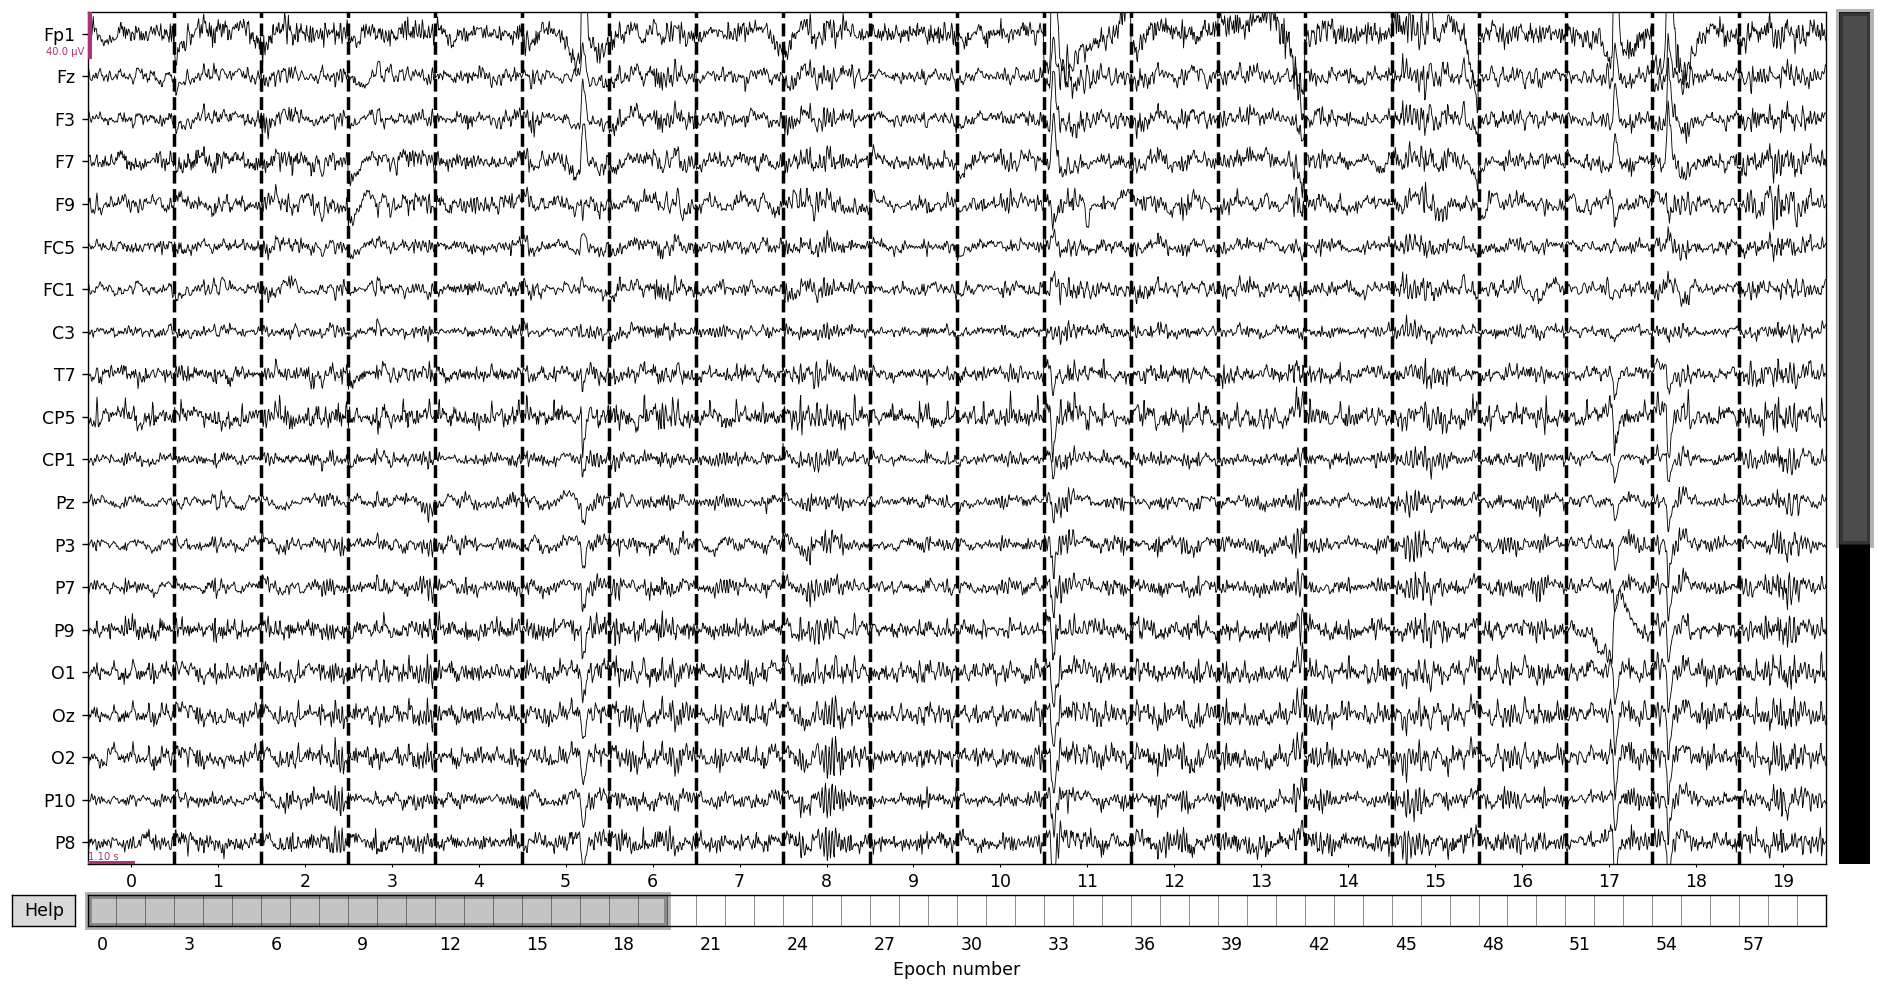

Dropped 0 epochs: 
The following epochs were marked as bad and are dropped:
[]
Channels marked as bad:
none


In [ ]:
epochs = mne.Epochs(raw, events, event_id=event_id, tmin=shift, \
            tmax=2.2+shift, baseline=(None, None), preload=False, verbose=False)
epochs.plot()

In [11]:
evoke2 = epochs["0.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.21.1.1.1.0.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.21.1.1.1.0.20.20.20.20.20.20.20.20.20.20.20.20.20.21.1.1.1.0.20.20.20.20.20.20.20.20.20.20.20.20.21.1.1.1.0.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.21.1.1.1.0.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.21.1.1.1.0.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.21.1.1.1.0.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.21.1.1.1.0.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.21.1.1.1.0.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.21.1.1.1.0.20.20.20.20.20.20.20.20.20.20.20.20.20.21.1.1.1.0.20.20.20.20.20.20.20.20.20.20.20.20.21.1.1.1.0.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.21.1.1.1.0.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.21.1.1.1.0.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.21.1.1.1.0.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.21.1.1.1.0.20.20.20.2_2"].average()
evoke3 = epochs["0.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.21.1.1.1.0.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.21.1.1.1.0.20.20.20.20.20.20.20.20.20.20.20.20.21.1.1.1.0.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.21.1.1.1.0.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.21.1.1.1.0.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.21.1.1.1.0.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.21.1.1.1.0.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.21.1.1.1.0.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.21.1.1.1.0.20.20.20.20.20.20.20.20.20.20.20.20.21.1.1.1.0.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.21.1.1.1.0.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.21.1.1.1.0.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.21.1.1.1.0.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.21.1.1.1.0.20.20.20.20.20.20.20.20.20.20.2_3"].average()
evoke4 = list(epochs["0.20.20.20.20.20.20.20.20.20.20.20.20.20.20.21.1.1.1.0.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.21.1.1.1.0.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.21.1.1.1.0.20.20.20.20.20.20.20.20.20.20.20.20.20.21.1.1.1.0.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.21.1.1.1.0.20.20.20.20.20.20.20.20.20.20.21.1.1.1.0.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.21.1.1.1.0.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.21.1.1.0.20.20.20.20.20.20.20.20.20.20.20.20.20.20.21.1.1.1.0.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.21.1.1.1.0.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.21.1.1.1.0.20.20.20.20.20.20.20.20.20.20.20.20.20.21.1.1.1.0.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.21.1.1.1.0.20.20.20.20.20.20.20.20.20.20.21.1.1.1.0.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.21.1.1.1.0.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.21.1.1._4"].iter_evoked())
evoke1 = list(epochs["0.21.1.1.1.0.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.21.1.1.1.0.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.21.1.1.1.0.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.21.1.1.1.0.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.21.1.1.1.0.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.21.1.1.1.0.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.21.1.1.1.0.20.20.20.20.20.20.20.20.20.20.20.20.20.21.1.1.1.0.20.20.20.20.20.21.1.1.1.0.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.21.1.1.1.0.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.21.1.1.1.0.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.21.1.1.1.0.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.21.1.1.1.0.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.21.1.1.1.0.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.20.21.1.1.1.0.20.20.20.20.20.20.20.20.20.20.20.20.20.21.1.1.1.0.20.20.20.20.2_1"].iter_evoked())
evokeds = dict(one=evoke1,four=evoke4)
# evoke1.plot(picks="eeg", spatial_colors=True, gfp=True)
mne.viz.plot_compare_evokeds(evokeds,"Oz",combine='mean')
mne.viz.plot_compare_evokeds(evokeds,"O1",combine='mean')
# evoke1.plot_topomap()
# evoke1.plot_joint()
# evoke2.plot(picks="eeg", spatial_colors=True, gfp=True)
# evoke3.plot(picks="eeg", spatial_colors=True, gfp=True)
# evoke4.plot(picks="eeg", spatial_colors=True, gfp=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


IndexError: list index out of range

### Transform a code in `str` to a code in np.array

In [879]:
def code2array(code):
    tmp = []
    for idx, c in enumerate(code[:-2]):
        if c == '5' or c == '.':
            continue
        elif c == '0':
            if code[idx+2] == '5':
                tmp.append(0.5)
            else:
                tmp.append(0)
        else:
            tmp.append(1)
    if code[-1] == '.':
        if code[-2] == '0':
            tmp.append(0)
        else:
            tmp.append(1)
    return np.array(tmp)

### Build a dictionnary that contains all the code in the np.array format

In [880]:
from collections import OrderedDict
codes = OrderedDict()
for k, v in event_id.items():
    code = k.split('_')[0]
    code = code.replace('.','').replace('2','')
    idx = k.split('_')[1]
    if 'randomslowwhite' in file_name:
        codes[v-1] = code2array(code) 
    else:
        codes[v-1] = np.array(list(map(int, code)))

### Define train/test split and windows size
Here we use only the first 7 blocks as calibrition and 8 others would be used as testing

In [881]:
codes

OrderedDict([(0,
              array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                     0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                     0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
                     1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
                     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0,
                     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0,
                     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
                     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
                     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                     0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                     0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                     0, 0,

In [882]:
print(data.shape)

(60, 32, 1101)


In [883]:
sfreq = int(epochs.info['sfreq'])
n_samples_windows = int(window_size*sfreq)
n_trial_per_class = int(len(data)/n_class)

n_cal = 5

data_train = data[:n_class*n_cal]
labels_train = labels[:n_class*n_cal]
data_test = data[n_class*n_cal:]
labels_test = labels[n_class*n_cal:]


### Slice the epoch in windows
The network is not processing full epochs but windows of 250ms. So each epoch is cut into window and the following code (`0` or `1`) is associated as label.

In [884]:
def to_window_old(data, labels):
    length = int((2.2-window_size)*sfreq)
    X = np.empty(shape=((length)*data.shape[0], n_channels, n_samples_windows))
    y = np.empty(shape=((length)*data.shape[0]), dtype=int)
    print(length)
    print(n_samples_windows)
    count = 0
    for trial_nb, trial in enumerate(data):
        lab = labels[trial_nb]
        c = codes[lab]
        code_pos = 0
        for idx in range(length):
            X[count] = trial[:, idx:idx+n_samples_windows]
            if idx/sfreq >= (code_pos+1)/fps:
                code_pos += 1 
            y[count] = int(c[code_pos])
            count += 1

    # X = np.expand_dims(X, 1)
    X = X.astype(np.float32)
    y_pred = np.vstack((y,np.abs(1-y))).T
    y = np.array([1 if (y >= 0.5) else 0 for y in y_pred[:,0]])
    return X, y

In [885]:
def to_window(data, labels, win_size, data_freq, code_freq, offset=0,
              focus_rising=None, pre_rising=0, post_rising=0,
              focus_falling=None, pre_falling=0, post_falling=0):
    length = int((2.2-win_size)*data_freq)
    X = np.empty(shape=((length)*data.shape[0], n_channels, n_samples_windows))
    Y = np.empty(shape=((length)*data.shape[0]), dtype=int)
    for trial_nb, trial in enumerate(data):
        lab = labels[trial_nb]
        c = codes[lab]
        labels_upsampled = np.repeat(c, sfreq//code_freq)
        labels_upsampled = np.concatenate((np.zeros(int(offset*data_freq), dtype=int), np.array(labels_upsampled)))
        if (focus_rising is not None) or (focus_falling is not None):
            hi_indices = []
            low_indices = []
            for idx in range(1, len(labels_upsampled)):
                if (focus_rising is not None) and (labels_upsampled[idx-1] == 0) and (labels_upsampled[idx] == 1):
                    hi_indices.append(idx)
                elif (focus_falling is not None) and (labels_upsampled[idx-1] == 1) and (labels_upsampled[idx] == 0):
                    low_indices.append(idx)
            focused_labels = np.zeros(length)
            pre_rising_frames = int(sfreq*pre_rising)
            post_rising_frames = int(sfreq*post_rising)
            pre_falling_frames = int(sfreq*pre_falling)
            post_falling_frames = int(sfreq*post_falling)
            for idx in hi_indices:
                focused_labels[idx-pre_rising_frames:idx+post_rising_frames+1] = 1
            for idx in low_indices:
                focused_labels[idx-pre_falling_frames:idx+post_falling_frames+1] = 1
        else:
            focused_labels = labels_upsampled.copy()
            
        for idx in range(length):
            # print('Xidx:', trial_nb*length+idx, "Tidxm:", idx, 'TidxM:', idx +
            #       n_samples_windows, 'Ltrial', trial[:, idx:idx+n_samples_windows].shape)
            X[trial_nb*length+idx] = trial[:, idx:idx+n_samples_windows]
            Y[trial_nb*length+idx] = focused_labels[idx]
    # X = np.expand_dims(X, 1)
    X = X.astype(np.float32)
    y_pred = np.vstack((Y,np.abs(1-Y))).T
    Y = [1 if (Y >= 0.5) else 0 for Y in y_pred[:,0]]
    return X, Y

In [886]:
def to_window_new(data, labels, win_size, code_freq, offset=0,
              focus_rising=None, pre_rising=0, post_rising=0):
    length = int((2.2-win_size)*code_freq)
    X = np.empty(shape=((length)*data.shape[0], n_channels, n_samples_windows))
    Y = np.empty(shape=((length)*data.shape[0]), dtype=int)
    idx_taken = []
    for trial_nb, trial in enumerate(data):
        lab = labels[trial_nb]
        c = codes[lab]
        labels_upsampled = np.repeat(c, code_freq//code_freq)
        labels_upsampled = np.concatenate((np.zeros(int(offset*code_freq), dtype=int), np.array(labels_upsampled)))
        if (focus_rising is not None):
            hi_indices = []
            for idx in range(1, len(labels_upsampled)):
                if (focus_rising is not None) and (labels_upsampled[idx-1] == 0) and (labels_upsampled[idx] == 1):
                    hi_indices.append(idx)
            focused_labels = np.zeros(length)
            pre_rising_frames = int(code_freq*pre_rising)
            post_rising_frames = int(code_freq*post_rising)
            for idx in hi_indices:
                focused_labels[idx:idx+4] = 1
                # focused_labels[idx+1:idx+4] = -1
                # focused_labels[idx-4:idx] = -1
                # idx_to_rm.append([trial_nb*length+idx+post_rising_frames+i for i in range (1,4-post_rising_frames)])
        else:
            focused_labels = labels_upsampled.copy()

        for idx in range(length):
            # print('Xidx:', trial_nb*length+idx, "Tidxm:", idx, 'TidxM:', idx +
            #       n_samples_windows, 'Ltrial', trial[:, idx:idx+n_samples_windows].shape)
            X[trial_nb*length+idx] = trial[:, idx:idx+n_samples_windows]
            Y[trial_nb*length+idx] = focused_labels[idx]
            idx_taken.append(trial_nb*length+idx)
    # X = np.expand_dims(X, 1)
    X = X.astype(np.float32)
    X = np.delete(X,np.where(Y==-1),0)
    idx_taken = np.delete(idx_taken,np.where(Y==-1))
    Y = np.delete(Y,np.where(Y==-1))
    # y_pred = np.vstack((Y,np.abs(1-Y))).T
    # Y = np.delete(Y[:,0],np.where(Y==-1))
    # Y = np.array([1 if (Y >= 0.5) else 0 for Y in y_pred[:,0]])
    return X, Y, idx_taken

In [887]:
window_size = 0.25
n_samples_windows = int(window_size*sfreq)
# X, Y = to_window_old(np.array(data_train[:1]), labels_train[:1])
# X_train, Y_train = to_window_old(data_train, labels_train)
# X_test, Y_test = to_window_old(data_test, labels_test)
# print(Y[:,0])
# X_train, Y_train = to_window_old(data_train, labels_train)#, 0.25, sfreq, 60)
# X_test, Y_test = to_window_old(data_test, labels_test)#, 0.25, sfreq, 60)
X_train, Y_train, frame_train = to_window_new(data_train, labels_train, window_size, 60, focus_rising=True)
X_test, Y_test, frame_test = to_window_new(data_test, labels_test, window_size, 60, focus_rising=True)
# print(codes[labels_test[0]])
print(Y_train.shape)
print(Y_test.shape)
print(frame_train.shape)

(2340,)
(4680,)
(2340,)


In [888]:
def onset_anno_old(onset_window,label_window,onset_code,nb_seq_min,nb_seq_max,sfreq,win_size):
    assert(sfreq!=0)
    new_onset = []
    current_code = 0
    nb_seq_min-=1
    onset_shift = onset_code[current_code+nb_seq_min]
    time_trial = (2.2-win_size)
    for i,o in enumerate(onset_window):
        if current_code==nb_seq_max-1-nb_seq_min:
            new_onset.append(o+onset_shift)
        else:
            if o+onset_shift >= onset_code[current_code+nb_seq_min]+time_trial*sfreq:
                current_code+=1
                onset_shift = onset_code[current_code+nb_seq_min]-time_trial*sfreq*current_code
            new_onset.append(o+onset_shift)
    
    # modified_onset_code = [onset_code[i]-time_trial*sfreq*i for i in range(nb_seq_min,nb_seq_max)]
    new_onset_0 = np.concatenate([np.arange(onset_code[i],onset_code[i]+time_trial*sfreq,sfreq//60) for i in range(nb_seq_min,nb_seq_max)])
    new_onset_0 = np.array(list(filter(lambda i: i not in new_onset, new_onset_0)))
    print(new_onset_0.shape)
    return np.array(new_onset)/sfreq, new_onset_0/sfreq
            

In [889]:
def onset_anno(onset_window,label_window,onset_code,nb_seq_min,nb_seq_max,code_freq,sfreq,win_size):
    assert(sfreq!=0)
    new_onset = []
    new_onset_0 = []
    current_code = 0
    onset_code = np.ceil(onset_code*code_freq/sfreq)
    nb_seq_min-=1
    onset_shift = onset_code[current_code+nb_seq_min]
    time_trial = (2.2-win_size)
    # onset_window = np.arange(0,time_trial*code_freq*(nb_seq_max-nb_seq_min)-1,1,dtype=int)
    for i,o in enumerate(onset_window):
        if label_window[i]==1:
            # print(i)
            if current_code==nb_seq_max-1-nb_seq_min:
                new_onset.append(o+onset_shift)
            else:
                if o+onset_shift >= onset_code[current_code+nb_seq_min]+time_trial*code_freq:
                    current_code+=1
                    onset_shift = onset_code[current_code+nb_seq_min]-time_trial*code_freq*current_code
                new_onset.append(o+onset_shift)
        else:
            if current_code==nb_seq_max-1-nb_seq_min:
                new_onset_0.append(o+onset_shift)
            else:
                if o+onset_shift >= onset_code[current_code+nb_seq_min]+time_trial*code_freq:
                    current_code+=1
                    onset_shift = onset_code[current_code+nb_seq_min]-time_trial*code_freq*current_code
                new_onset_0.append(o+onset_shift)
    
    # modified_onset_code = [onset_code[i]-time_trial*sfreq*i for i in range(nb_seq_min,nb_seq_max)]
    # new_onset_0 = np.concatenate([np.arange(onset_code[i],onset_code[i]+time_trial*sfreq,sfreq//60) for i in range(nb_seq_min,nb_seq_max)])
    new_onset_0 = np.array(list(filter(lambda i: i not in new_onset, new_onset_0)))
    # print(new_onset_0.shape)
    return np.array(new_onset)/code_freq, np.array(new_onset_0)/code_freq
            

In [890]:
# print(Y_train)
# print(np.where(Y_train==1)[0]*sfreq//60)
# print(frame_train)
onset_train,onset_train_0 = onset_anno(frame_train,Y_train,onset_code,1,n_class*n_cal,60,500,window_size)
print(onset_train,onset_train_0)
anno = mne.Annotations(onset_train,0.001*sfreq//60,"1")
anno.append(onset_train_0,0.001*sfreq//60,"0")
onset_test,onset_test_0 = onset_anno(frame_test,Y_test,onset_code,n_class*n_cal+1,60,60,500,window_size)
anno.append(onset_test,0.001*sfreq//60,"1")
anno.append(onset_test_0,0.001*sfreq//60,"0")
raw = raw.set_annotations(anno)
# raw.plot(n_channels=15, duration=300)

[23.31666667 23.33333333 23.35       23.36666667 23.7        23.71666667
 23.73333333 23.75       24.         24.01666667 24.03333333 24.05
 24.28333333 24.3        24.31666667 24.33333333 24.61666667 24.63333333
 24.65       24.66666667 26.36666667 26.38333333 26.4        26.41666667
 26.85       26.86666667 26.88333333 26.9        27.31666667 27.33333333
 27.35       27.36666667 27.73333333 27.75       27.76666667 27.78333333
 28.16666667 28.18333333 28.2        28.21666667 30.01666667 30.03333333
 30.05       30.06666667 30.45       30.46666667 30.48333333 30.5
 30.91666667 30.93333333 30.95       30.96666667 31.21666667 31.23333333
 31.25       31.26666667 31.65       31.66666667 31.68333333 31.7
 33.48333333 33.5        33.51666667 33.53333333 33.88333333 33.9
 33.91666667 33.93333333 34.16666667 34.18333333 34.2        34.21666667
 34.53333333 34.55       34.56666667 34.58333333 35.         35.01666667
 35.03333333 35.05       38.28333333 38.3        38.31666667 38.33333333
 38.6

In [891]:
events, event_id = mne.events_from_annotations(raw)
print(event_id,events)
epochs = mne.Epochs(raw, events, event_id=event_id, tmin=0, \
            tmax=0.6, baseline=(None, None), preload=False, verbose=False)
# epochs.plot()

Used Annotations descriptions: ['0', '1']


{'0': 1, '1': 2} [[ 11467      0      1]
 [ 11475      0      1]
 [ 11483      0      1]
 [ 11492      0      1]
 [ 11500      0      1]
 [ 11508      0      1]
 [ 11517      0      1]
 [ 11525      0      1]
 [ 11533      0      1]
 [ 11542      0      1]
 [ 11550      0      1]
 [ 11558      0      1]
 [ 11567      0      1]
 [ 11575      0      1]
 [ 11583      0      1]
 [ 11592      0      1]
 [ 11600      0      1]
 [ 11608      0      1]
 [ 11617      0      1]
 [ 11625      0      1]
 [ 11633      0      1]
 [ 11642      0      1]
 [ 11650      0      1]
 [ 11658      0      2]
 [ 11667      0      2]
 [ 11675      0      2]
 [ 11683      0      2]
 [ 11692      0      1]
 [ 11700      0      1]
 [ 11708      0      1]
 [ 11717      0      1]
 [ 11725      0      1]
 [ 11733      0      1]
 [ 11742      0      1]
 [ 11750      0      1]
 [ 11758      0      1]
 [ 11767      0      1]
 [ 11775      0      1]
 [ 11783      0      1]
 [ 11792      0      1]
 [ 11800      0      1]

In [892]:
epochs_train1 = mne.Epochs(raw,events, 2,tmin=-0.01,tmax=window_size)
epochs_train0 = mne.Epochs(raw,events, 1,tmin=-0.01,tmax=window_size)
# epochs_train1.plot()

Not setting metadata
1200 matching events found
Setting baseline interval to [-0.01, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated


Not setting metadata
5820 matching events found
Setting baseline interval to [-0.01, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated


In [893]:
evoked_1 = list(epochs_train1.iter_evoked())
# evoked_1.plot(picks="Oz")
evoked_0 = list(epochs_train0.iter_evoked())
# evoked_0.plot(picks="Oz")
evokeds = dict(one=evoked_1,zero=evoked_0)
mne.viz.plot_compare_evokeds(evokeds, combine="mean", picks="Oz")

combining channels using "mean"


C:\Users\s.velut\AppData\Local\Temp\ipykernel_15820\2255816275.py:6: RuntimeWarning: Only 1 channel in "picks"; cannot combine by method "mean".
  mne.viz.plot_compare_evokeds(evokeds, combine="mean", picks="Oz")


combining channels using "mean"


C:\Users\s.velut\AppData\Local\Temp\ipykernel_15820\2255816275.py:6: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  mne.viz.plot_compare_evokeds(evokeds, combine="mean", picks="Oz")


[<Figure size 1000x750 with 1 Axes>]

In [894]:
epochs = mne.Epochs(raw,events,event_id,tmin=-0.01,tmax=0.3)
X=epochs.get_data()
print(frame_train.shape)
label = epochs.events[...,-1]
label.shape
size_train = frame_train.shape[0] #int((2.2-window_size)*n_class*n_cal*60)
X_train = X[:size_train]
X_test = X[size_train:]
Y_train = label[:size_train]-1
Y_test = label[size_train:]-1

Not setting metadata
7020 matching events found
Setting baseline interval to [-0.01, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 7020 events and 156 original time points ...
0 bad epochs dropped
(2340,)


### Normalization using stats from the train set

In [895]:
X_std = X_train.std(axis=0)
X_train /= X_std + 1e-8
X_std = X_test.std(axis=0)
X_test /= X_std + 1e-8

### Balance classes
Our classes are unbalanced, there are more `1` than `0` in the train set (the stimulation is more often ON than OFF).  
We will use a random under sampler to make it balance.

In [896]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(len(Y_train[Y_train[:] == 1]))
print(len(Y_train[Y_train[:] == 2]))
print(Y_test.shape)
print(len(Y_test[Y_test[:] == 2]))


(2340, 32, 156)
(4680, 32, 156)
(2340,)
400
0
(4680,)
0


In [897]:

# rus = RandomUnderSampler()
# counter=np.array(range(0,len(Y_train))).reshape(-1,1)
# index,_ = rus.fit_resample(counter,Y_train[:])
# X_train = np.squeeze(X_train[index,:,:], axis=1)
# Y_train = np.squeeze(Y_train[index])
# rus = RandomUnderSampler()
# counter=np.array(range(0,len(Y_test))).reshape(-1,1)
# index,_ = rus.fit_resample(counter,Y_test[:])
# X_test = np.squeeze(X_test[index,:,:], axis=1)
# Y_test = np.squeeze(Y_test[index])



In [898]:
print(len(Y_train[Y_train[:] == 1]))
print(len(Y_train[Y_train[:] == 2]))
print(len(Y_test[Y_test[:] == 1]))
print(len(Y_test[Y_test[:] == 2]))

400
0
800
0


### Pick an architecture

In [899]:
#  clf = basearchi_patchembedding(windows_size = n_samples_windows, n_channel_input = n_channels) # other stim
# clf = basearchi_patchembeddingdilation(windows_size = n_samples_windows, n_channel_input = n_channels) # burst
# clf = vanilliaEEG2Code(windows_size = n_samples_windows, n_channel_input = n_channels) # burst
# clf = trueVanilliaEEG2Code(windows_size = n_samples_windows, n_channel_input = n_channels) # burst
# clf = basearchitest(windows_size = n_samples_windows, n_channel_input = n_channels)
#c lf = basearchitest_batchnorm(windows_size = n_samples_windows, n_channel_input = n_channels)
# clf = EEGnet_Inception(windows_size = n_samples_windows, n_channel_input = n_channels)
# clf = basearchi(windows_size = n_samples_windows, n_channel_input = n_channels)

from sklearn.svm import SVR


clf = make_pipeline(XdawnCovariances(nfilter=4, estimator="oas", xdawn_estimator="lwf"),MDM())
clf2 = make_pipeline(XdawnCovariances(nfilter=4, estimator="lwf", xdawn_estimator="lwf"),
    TangentSpace(),
    LDA(solver="lsqr", shrinkage="auto"))
clf3 = make_pipeline(XdawnCovariances(nfilter=4, estimator="oas", xdawn_estimator="lwf"),
    TangentSpace(),
    svm.SVC())
clf4 = make_pipeline(Xdawn(nfilter=4, estimator="lwf"),Vectorizer(),LDA(solver="lsqr", shrinkage="auto"))
clf5 = make_pipeline(CSP(n_components=4, reg=None, log=True, norm_trace=False),svm.SVC())

rm = SVR()

# xdawn = XdawnCovariances(nfilter=3, estimator="lwf", xdawn_estimator="scm")
# clf = MDM()


# clf.steps

In [900]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)



(2340, 32, 156)
(2340,)
(4680, 32, 156)
(4680,)


### Cut the train in train and valid
Also set some HP of the network

In [901]:
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42, shuffle=True)
batchsize = 128 #128 # 64 for burst
epochs = 45 #45 # 20 for burst

### Attach an optimizer and train the network

res_X_train=[]
for i in range(len(X_train)):
    res_X_train.append(np.array(X_train[i:i+1]).reshape(n_samples_windows, n_channels, 1))
res_X_val=[]
for i in range(len(x_val)):
    res_X_val.append(np.array(x_val[i:i+1]).reshape(n_samples_windows, n_channels, 1))

np.array(res_X_val).shape

np.array(res_X_train).shape

In [902]:
# lr = 1e-3
# weight_decay = 1e-4
# optimizer = keras.optimizers.Adam(learning_rate=lr, amsgrad=True)
# clf.compile(loss='binary_crossentropy',optimizer=optimizer, metrics=['accuracy'])
# X_trainp = xdawn.fit_transform(X_train,y_train)
# X_valp = xdawn.fit_transform(x_val,y_val)
# X_testp = xdawn.fit_transform(X_test,Y_test)>
history = clf.fit(np.array(x_train), y_train)
history2 = clf2.fit(np.array(x_train), y_train)
history3 = clf3.fit(np.array(x_train), y_train)
history4 = clf4.fit(np.array(x_train), y_train)

reg_x_train = x_train.reshape(x_train.shape[0], x_train.shape[1] * x_train.shape[2])
# history_r1 = rm.fit(np.array(reg_x_train), y_train)
# history5 = clf5.fit(np.array(x_train), y_train)
keras.backend.clear_session()


In [903]:
# rm.score(X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2]),Y_test)
# pred = rm.predict(X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2]))
# y_pred = [1 if (Y >= 0.5) else 0 for Y in pred]
# print(np.count_nonzero(y_pred==Y_test)/len(Y_test))

In [904]:
from sklearn.metrics import balanced_accuracy_score


print("RG")
print(balanced_accuracy_score(y_train,history.predict(x_train)))
print(balanced_accuracy_score(y_val,history.predict(x_val)))
print(balanced_accuracy_score(Y_test,history.predict(X_test)))

print("RG+LDA")
print(balanced_accuracy_score(y_train,history2.predict(x_train)))
print(balanced_accuracy_score(y_val,history2.predict(x_val)))
print(balanced_accuracy_score(Y_test,history2.predict(X_test)))

print("RG+SVC")
print(balanced_accuracy_score(y_train,history3.predict(x_train)))
print(balanced_accuracy_score(y_val,history3.predict(x_val)))
print(balanced_accuracy_score(Y_test,history3.predict(X_test)))

print("Xdw+LDA")
print(balanced_accuracy_score(y_train,history4.predict(x_train)))
print(balanced_accuracy_score(y_val,history4.predict(x_val)))
print(balanced_accuracy_score(Y_test,history4.predict(X_test)))

# print("CSP+LDA")
# print(history5.score(x_train,y_train))
# print(history5.score(x_val,y_val))
# print(history5.score(X_test,Y_test))
# print(history.predict(X_trainp)==y_train)

RG
0.7968784148029431
0.7261784405408821
0.7069072164948453
RG+LDA
0.8209975474126417
0.7279792746113989
0.6765528350515464
RG+SVC
0.9198113207547169
0.7261468469606975
0.6165657216494845
Xdw+LDA
0.8272504310240159
0.7019145709591811
0.7112048969072164


### Model and accuracy and loss
Just check that the model learnt something

In [543]:
plt.figure(figsize=(12,12))
# summarize history for accuracy
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# summarize history for loss
plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
print()


AttributeError: 'Pipeline' object has no attribute 'history'

filename = ''
np.save(filename + "std_from_calibration", X_std)
model_filename = os.path.join(os.getcwd(), filename + '0.7' + "trainedmodel")
# Save the model if calibration was done
clf.save(model_filename)
keras.backend.clear_session()

## Vizualize learned filters
### Raw vizualiation of 1D convolutinal kernel of the first layer --> spatial filters

In [905]:
# # We first visualize the learned patch embeddings.
# patch_embeddings = clf.layers[0].get_weights()[0]
# weights = patch_embeddings
# # First, apply min-max normalization to the
# # given weights to avoid isotrophic scaling.
# p_min, p_max = weights.min(), weights.max()
# weights = (weights - p_min) / (p_max - p_min)

# # Visualize all the filters.
# num_filters = 10
# plt.figure(figsize=(16, 2))
# idx = 1
# for i in range(num_filters):
#     current_weight = weights[:, :, :, i]
#     if current_weight.shape[-1] == 1:
#         current_weight = current_weight.squeeze()
#     ax = plt.subplot(1, 10, idx)
#     ax.set_xticks([])
#     ax.set_yticks([])
#     plt.plot(current_weight)
#     idx += 1

### Viz of the corresponding topo maps

In [906]:
# spatialfilts = clf.get_layer("conv2d").get_weights()[0]
# spatialfilts = np.squeeze(spatialfilts)
# spatialfilts = np.swapaxes(spatialfilts, 1, 0)

### Predict on the test set
The predictions are made on windows to regress the code.  
Here we divide the prediction in 10 fold to avoid OOM from the GPU.

In [907]:
keras.backend.clear_session()

In [908]:
keras.backend.clear_session()
y_pred = history4.predict(X_test)
y_pred = np.array(y_pred)

In [909]:
# y_pred_norm = np.array([1 if (y >= 0.5) else 0 for y in y_pred])
# y_test_norm = np.array([0 if y == 0 else 1 for y in Y_test])
y_pred_norm = y_pred
y_test_norm = Y_test

In [910]:
import sklearn.metrics
import math
tn, fp, fn, tp = sklearn.metrics.confusion_matrix(y_test_norm, y_pred_norm).ravel()
print("True positives:", tp)
print("True negatives:", tn)
print("False positives:", fp)
print("False negatives:", fn)
print("Accuracy:", (tp+tn)/len(y_test_norm))
print("Sensitivity:", sen:=tp/(tp+fn))
print("Precision:", pre:=tp/(tp+fp))
print("Fowlkes-Mallows:", math.sqrt(sen*pre))


True positives: 407
True negatives: 3545
False positives: 335
False negatives: 393
Accuracy: 0.8444444444444444
Sensitivity: 0.50875
Precision: 0.5485175202156334
Fowlkes-Mallows: 0.5282596789550604


### Convert prediction on windows (regressed code) to label prediction

It is offline and synchronous, so we will:
1. First create a `code_buffer` that contains the regressed code on the full epoch (2.2s - the last window)
    - The refresh rate of the EEG device (500 Hz) is faster than the refress rate of the screen (60Hz), so we average predictions (500/60~8 samples) so they correspond to each flip of the screen.
2. Starting from `min_len` (in number of samples), we compute Pearson correalation with the bank of templates code to find the closest one
    - If the most correlated code has a significantely bigger correlation compared to the second one (50% bigger) and the p_value is significative then the trial is classified and we move to the next one
    - If the thresholds are not reached, then we add samples (with a step of 3) to have a longer trial and re-do the computation
    - The thresholds can never been reached in 2.2s, then the trial is not classified.

In [911]:
# p_best_score = 0
# p_best_ratio = 0
# p_best_acc = 0
# p_best_values = ()

# for p in np.logspace(0,-5, 6):
#     for dr in np.linspace(0.2, 0.8, 7):
#         labels_pred, _, mean_long = make_preds_pvalue(y_pred, codes, min_len=70, sfreq=sfreq, obj_p=p)
#         ratio = len(labels_pred[labels_pred != -1])/len(labels_pred)
#         accuracy = accuracy_score(labels_test[labels_pred != -1], labels_pred[labels_pred != -1])
#         score = ratio*accuracy
#         if ratio >= p_best_ratio:
#             p_best_score = score
#             p_best_acc = accuracy
#             p_best_ratio = ratio
#             p_best_values = (p, dr)
#         print("==========", p, "+", dr,':',ratio,'--',accuracy,'--',score, '--', np.mean(mean_long))
# print("Best score", p_best_score)
# print("Best values", p_best_values)            
        

### Compute accuracy score and accuracy score when a prediction is made (discard not classified trials)

### Other classification method
Same as before but the classification method is different. Instead of thresholds to reach, if when increasing trial lengt a code correllated the most 40 times in a row then the trial is labeled.

In [912]:
# import importlib
# importlib.reload(_utils)
# from _utils import make_preds_accumul_aggresive, make_preds_pvalue



In [913]:
acc_best_score=0
acc_best_ratio=0
acc_best_acc=0
acc_best_value = 0
# for minlen in np.linspace(10, 60, 10):
for cons in [15, 20, 25, 30, 35, 40, 45, 50, 55, 60]:
    
    labels_pred_accumul, _, mean_long_accumul = make_preds_accumul_aggresive(
        y_pred_norm, codes, min_len=30, sfreq=60, consecutive=cons, window_size=window_size
    )
    print(labels_pred_accumul)
    print(labels_test)
    ratio = np.round(len(labels_pred_accumul[labels_pred_accumul != -1])/len(labels_pred_accumul), 2)
    accuracy = np.round(accuracy_score(labels_test[labels_pred_accumul!=-1], labels_pred_accumul[labels_pred_accumul!=-1]), 2)
    score = np.round(ratio*accuracy,2)
    print("==========", cons, ':', ratio, '--', accuracy,
        '--', score, '--', np.mean(mean_long_accumul))
    if accuracy > acc_best_acc:
        acc_best_score = score
        acc_best_value = cons
        acc_best_acc = accuracy
        acc_best_ratio = ratio

print("Best accuracy", acc_best_acc)
print("Best ratio", acc_best_ratio)
print("Best score", acc_best_score)
print("Best values", acc_best_value)


[0 2 1 3 3 1 2 2 1 0 1 3 3 2 2 0 0 3 1 1 3 2 1 1 2 1 3 2 1 3 2 0 2 2 2 2 2
 1 3 2]
[0 2 1 3 3 2 0 1 1 0 2 3 3 1 2 0 0 3 1 2 3 2 1 0 2 0 3 1 1 3 2 0 0 1 3 2 0
 1 3 2]
========== 15 : 1.0 -- 0.68 -- 0.68 -- 0.8083333333333333


c:\Users\s.velut\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\s.velut\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\s.velut\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\s.velut\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


[0 2 1 3 3 2 2 1 1 0 1 3 3 2 2 0 0 3 1 1 3 2 1 0 2 1 3 2 1 3 2 0 0 2 3 2 2
 1 3 2]
[0 2 1 3 3 2 0 1 1 0 2 3 3 1 2 0 0 3 1 2 3 2 1 0 2 0 3 1 1 3 2 0 0 1 3 2 0
 1 3 2]
========== 20 : 1.0 -- 0.8 -- 0.8 -- 0.9483333333333335
[0 2 1 3 3 2 2 1 1 0 1 3 3 2 2 0 0 3 1 1 3 2 1 0 2 1 3 2 1 3 2 0 0 2 3 2 2
 1 3 2]
[0 2 1 3 3 2 0 1 1 0 2 3 3 1 2 0 0 3 1 2 3 2 1 0 2 0 3 1 1 3 2 0 0 1 3 2 0
 1 3 2]
========== 25 : 1.0 -- 0.8 -- 0.8 -- 1.0316666666666667


c:\Users\s.velut\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\s.velut\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\s.velut\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\s.velut\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


[0 2 1 3 3 1 2 1 1 0 1 3 3 2 2 0 0 3 1 1 3 2 1 0 2 1 3 2 1 3 2 0 0 2 3 2 2
 1 3 2]
[0 2 1 3 3 2 0 1 1 0 2 3 3 1 2 0 0 3 1 2 3 2 1 0 2 0 3 1 1 3 2 0 0 1 3 2 0
 1 3 2]
========== 30 : 1.0 -- 0.78 -- 0.78 -- 1.105128205128205


c:\Users\s.velut\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\s.velut\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\s.velut\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\s.velut\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


[0 2 1 3 3 1 2 1 1 0 1 3 3 2 2 0 0 3 1 1 3 2 1 0 2 1 3 2 1 3 2 0 0 1 3 2 2
 1 3 2]
[0 2 1 3 3 2 0 1 1 0 2 3 3 1 2 0 0 3 1 2 3 2 1 0 2 0 3 1 1 3 2 0 0 1 3 2 0
 1 3 2]
========== 35 : 1.0 -- 0.8 -- 0.8 -- 1.191228070175439
[0 2 1 3 3 1 2 1 1 0 1 3 3 2 2 0 0 3 1 1 3 2 1 0 2 1 3 2 1 3 2 0 0 1 3 2 0
 1 3 2]
[0 2 1 3 3 2 0 1 1 0 2 3 3 1 2 0 0 3 1 2 3 2 1 0 2 0 3 1 1 3 2 0 0 1 3 2 0
 1 3 2]
========== 40 : 1.0 -- 0.82 -- 0.82 -- 1.2903508771929821


c:\Users\s.velut\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\s.velut\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


[0 2 1 3 3 1 2 1 1 0 1 3 3 2 2 0 0 3 1 2 3 2 1 0 2 1 3 2 1 3 2 0 0 1 3 2 0
 1 3 2]
[0 2 1 3 3 2 0 1 1 0 2 3 3 1 2 0 0 3 1 2 3 2 1 0 2 0 3 1 1 3 2 0 0 1 3 2 0
 1 3 2]
========== 45 : 1.0 -- 0.85 -- 0.85 -- 1.362037037037037


c:\Users\s.velut\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\s.velut\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


[0 2 1 3 3 1 2 1 1 0 1 3 3 2 2 0 0 3 1 2 3 2 1 0 2 1 3 2 1 3 2 0 0 1 3 2 0
 1 3 2]
[0 2 1 3 3 2 0 1 1 0 2 3 3 1 2 0 0 3 1 2 3 2 1 0 2 0 3 1 1 3 2 0 0 1 3 2 0
 1 3 2]
========== 50 : 1.0 -- 0.85 -- 0.85 -- 1.4171568627450981


c:\Users\s.velut\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\s.velut\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


[0 2 1 3 3 1 2 1 1 0 1 3 3 1 2 0 0 3 1 2 3 2 1 0 2 1 3 1 1 3 2 0 0 1 3 2 0
 1 3 2]
[0 2 1 3 3 2 0 1 1 0 2 3 3 1 2 0 0 3 1 2 3 2 1 0 2 0 3 1 1 3 2 0 0 1 3 2 0
 1 3 2]
========== 55 : 1.0 -- 0.9 -- 0.9 -- 1.5086021505376344


c:\Users\s.velut\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\s.velut\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


[0 2 1 3 3 1 2 1 1 0 1 3 3 1 2 0 0 3 1 2 3 2 1 0 2 1 3 1 1 3 2 0 0 1 3 2 0
 1 3 2]
[0 2 1 3 3 2 0 1 1 0 2 3 3 1 2 0 0 3 1 2 3 2 1 0 2 0 3 1 1 3 2 0 0 1 3 2 0
 1 3 2]
========== 60 : 1.0 -- 0.9 -- 0.9 -- 1.5811111111111107
Best accuracy 0.9
Best ratio 1.0
Best score 0.9
Best values 55


In [693]:
accuracy_score(labels_test[labels_pred_accumul!=-1], labels_pred_accumul[labels_pred_accumul!=-1])

0.85

In [101]:
labels_pred_accumul, aaaaa, mean_long_accumul = make_preds_accumul_aggresive(
        y_pred_norm, codes, min_len=30, sfreq=sfreq, consecutive=15, window_size=window_size
    )

c:\Users\s.velut\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\s.velut\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [ ]:
len(labels_pred_accumul)


In [ ]:
codes